In [1]:
import itertools
import os
import random
import subprocess

import IPython.display
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
BASENAME_CSV = 'sorted-20241127_183014' 
I_MAP = 1

DIRECTORY_IMAGES = f'images/{BASENAME_CSV}'
os.makedirs(DIRECTORY_IMAGES, exist_ok=True)    

df_orig = pd.read_csv(f'../logs/rundirs/{BASENAME_CSV}.csv')
df_orig

,Date,Scenario ID,Vehicle ID,Vehicle type,Cycle distance (m),No. of completed missions,Total distance traveled (m),No. of stops,No. of forcing events,No. of violations,...,blocked,"position (x, y), m","traveled, m",path index,no. poses,CP (index),"posTo Slow, m","distance ToCP, m",status,future missions
0,20241127_160216,map-generator/generated-maps/2024-11-22_11:26:...,0,HumanDrivenVehicle,783.84,0,585.1,7,0,0,...,NaN,"(248.7, 148.6)",585.1,585,784,585,585.1,1.0,STOP@CP,"2: [782, 784]"
1,20241127_160216,map-generator/generated-maps/2024-11-22_11:26:...,1,AutonomousVehicle,128.74,28,7397.7,29,0,0,...,NaN,"(102.1, 168.6)",242.7,239,254,NaN,225.1,NaN,DRIVING,1: [254]
2,20241127_160216,map-generator/generated-maps/2024-11-22_11:26:...,2,AutonomousVehicle,447.70,9,8710.2,11,0,0,...,NaN,"(233.9, 307.5)",665.9,664,894,NaN,862.8,NaN,DRIVING,1: [894]
3,20241127_160216,map-generator/generated-maps/2024-11-22_11:26:...,3,AutonomousVehicle,472.77,9,8638.5,11,0,0,...,NaN,"(283.5, 394.3)",142.8,142,944,247,214.6,105.3,DRIVING,1: [944]
4,20241127_160216,map-generator/generated-maps/2024-11-22_11:26:...,4,AutonomousVehicle,759.20,6,9528.2,6,0,0,...,NaN,"(685.0, 136.3)",426.6,425,1516,NaN,1485.8,NaN,DRIVING,1: [1516]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,20241127_181318,map-generator/generated-maps/2024-11-22_11:27:...,0,HumanDrivenVehicle,779.77,11,9091.7,11,15,15,...,NaN,"(556.3, 92.4)",531.0,530,778,NaN,746.4,NaN,DRIVING,"2: [780, 778]"
296,20241127_181318,map-generator/generated-maps/2024-11-22_11:27:...,1,AutonomousVehicle,132.88,19,5035.8,41,0,0,...,NaN,"(99.5, 158.1)",19.8,19,262,41,25.7,23.2,DRIVING,1: [262]
297,20241127_181318,map-generator/generated-maps/2024-11-22_11:27:...,2,AutonomousVehicle,328.57,11,7464.8,21,0,0,...,NaN,"(144.0, 162.1)",255.0,254,654,NaN,624.7,NaN,DRIVING,1: [654]
298,20241127_181318,map-generator/generated-maps/2024-11-22_11:27:...,3,AutonomousVehicle,496.72,8,7935.0,18,0,0,...,NaN,"(288.0, 535.7)",1.4,1,990,457,426.1,457.5,DRIVING,1: [990]


In [3]:
df_id = df_orig['Scenario ID'].str.split(r'[;,] ', expand=True)
df_id.columns = ['filename', 'Coordination strategy', 'string_seed', 'string_probabilityForcingForHuman', 'heuristic']
df_id = pd.concat([
    df_id,
    df_id['filename'].str.extract(r'(?P<dir_map>[^/]+)/(?P<basename_scenario>[^/]+)[.]json$', expand=True),
    df_id['filename'].str.extract(r'/scenario(?P<i_map>\d+)-(?P<i_locations>\d+)[.]json$', expand=True).astype(int),
    df_id['string_probabilityForcingForHuman'].str.extract(r'^probabilityForcingForHuman (?P<probabilityForcingForHuman>[\d.]+)$', expand=True).astype(float),
], axis=1).rename(columns={'i_locations': 'Positions variant'})
df_id['filename_screenshot'] = "../map-generator/generated-maps/" + df_id['dir_map'] + '/screenshots/' + df_id['basename_scenario'] + '.png'
df_id['are_bridges'] = df_id['dir_map'].str.contains('with_bridges')
df_id['configuration'] = df_id[
    ['i_map', 'are_bridges', 'Positions variant']].agg(
    lambda r: f'map {r['i_map']}, {"with" if r['are_bridges'] else "without"} bridges, pos.var. {r['Positions variant']}', 
    axis=1
)
df_id = df_id.sort_values(['i_map', 'are_bridges', 'Positions variant'], ascending=[True, False, True])
df_id = df_id[df_id['i_map'] == I_MAP]
df_id

,filename,Coordination strategy,string_seed,string_probabilityForcingForHuman,heuristic,dir_map,basename_scenario,i_map,Positions variant,probabilityForcingForHuman,filename_screenshot,are_bridges,configuration
0,map-generator/generated-maps/2024-11-22_11:26:...,baseline,seed 1,probabilityForcingForHuman 0,AUTOMATED_FIRST,2024-11-22_11:26:14_with_bridges,scenario1-1,1,1,0.0,../map-generator/generated-maps/2024-11-22_11:...,True,"map 1, with bridges, pos.var. 1"
1,map-generator/generated-maps/2024-11-22_11:26:...,baseline,seed 1,probabilityForcingForHuman 0,AUTOMATED_FIRST,2024-11-22_11:26:14_with_bridges,scenario1-1,1,1,0.0,../map-generator/generated-maps/2024-11-22_11:...,True,"map 1, with bridges, pos.var. 1"
2,map-generator/generated-maps/2024-11-22_11:26:...,baseline,seed 1,probabilityForcingForHuman 0,AUTOMATED_FIRST,2024-11-22_11:26:14_with_bridges,scenario1-1,1,1,0.0,../map-generator/generated-maps/2024-11-22_11:...,True,"map 1, with bridges, pos.var. 1"
3,map-generator/generated-maps/2024-11-22_11:26:...,baseline,seed 1,probabilityForcingForHuman 0,AUTOMATED_FIRST,2024-11-22_11:26:14_with_bridges,scenario1-1,1,1,0.0,../map-generator/generated-maps/2024-11-22_11:...,True,"map 1, with bridges, pos.var. 1"
4,map-generator/generated-maps/2024-11-22_11:26:...,baseline,seed 1,probabilityForcingForHuman 0,AUTOMATED_FIRST,2024-11-22_11:26:14_with_bridges,scenario1-1,1,1,0.0,../map-generator/generated-maps/2024-11-22_11:...,True,"map 1, with bridges, pos.var. 1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,map-generator/generated-maps/2024-11-22_11:27:...,stops,seed 1,probabilityForcingForHuman 1,AUTOMATED_FIRST,2024-11-22_11:27:17_without_bridges,scenario1-10,1,10,1.0,../map-generator/generated-maps/2024-11-22_11:...,False,"map 1, without bridges, pos.var. 10"
176,map-generator/generated-maps/2024-11-22_11:27:...,stops,seed 1,probabilityForcingForHuman 1,AUTOMATED_FIRST,2024-11-22_11:27:17_without_bridges,scenario1-10,1,10,1.0,../map-generator/generated-maps/2024-11-22_11:...,False,"map 1, without bridges, pos.var. 10"
177,map-generator/generated-maps/2024-11-22_11:27:...,stops,seed 1,probabilityForcingForHuman 1,AUTOMATED_FIRST,2024-11-22_11:27:17_without_bridges,scenario1-10,1,10,1.0,../map-generator/generated-maps/2024-11-22_11:...,False,"map 1, without bridges, pos.var. 10"
178,map-generator/generated-maps/2024-11-22_11:27:...,stops,seed 1,probabilityForcingForHuman 1,AUTOMATED_FIRST,2024-11-22_11:27:17_without_bridges,scenario1-10,1,10,1.0,../map-generator/generated-maps/2024-11-22_11:...,False,"map 1, without bridges, pos.var. 10"


In [4]:
configuration_to_filename_screenshot = {row['configuration']: row['filename_screenshot'] for _, row in df_id.iterrows()}
configuration_to_filename_screenshot

{'map 1, with bridges, pos.var. 1': '../map-generator/generated-maps/2024-11-22_11:26:14_with_bridges/screenshots/scenario1-1.png',
 'map 1, with bridges, pos.var. 2': '../map-generator/generated-maps/2024-11-22_11:26:14_with_bridges/screenshots/scenario1-2.png',
 'map 1, with bridges, pos.var. 3': '../map-generator/generated-maps/2024-11-22_11:26:14_with_bridges/screenshots/scenario1-3.png',
 'map 1, with bridges, pos.var. 4': '../map-generator/generated-maps/2024-11-22_11:26:14_with_bridges/screenshots/scenario1-4.png',
 'map 1, with bridges, pos.var. 5': '../map-generator/generated-maps/2024-11-22_11:26:14_with_bridges/screenshots/scenario1-5.png',
 'map 1, with bridges, pos.var. 6': '../map-generator/generated-maps/2024-11-22_11:26:14_with_bridges/screenshots/scenario1-6.png',
 'map 1, with bridges, pos.var. 7': '../map-generator/generated-maps/2024-11-22_11:26:14_with_bridges/screenshots/scenario1-7.png',
 'map 1, with bridges, pos.var. 8': '../map-generator/generated-maps/2024-11

In [5]:
index_id = df_orig.columns.get_loc('Scenario ID')
df = pd.concat([
    df_id[['i_map', 'are_bridges', 'Positions variant', 'configuration', 
           'Coordination strategy', 'probabilityForcingForHuman']], 
    df_orig.iloc[:, index_id + 1:]], 
    axis=1
)
df

,i_map,are_bridges,Positions variant,configuration,Coordination strategy,probabilityForcingForHuman,Vehicle ID,Vehicle type,Cycle distance (m),No. of completed missions,...,blocked,"position (x, y), m","traveled, m",path index,no. poses,CP (index),"posTo Slow, m","distance ToCP, m",status,future missions
0,1,True,1,"map 1, with bridges, pos.var. 1",baseline,0.0,0,HumanDrivenVehicle,783.84,0,...,NaN,"(248.7, 148.6)",585.1,585,784,585,585.1,1.0,STOP@CP,"2: [782, 784]"
1,1,True,1,"map 1, with bridges, pos.var. 1",baseline,0.0,1,AutonomousVehicle,128.74,28,...,NaN,"(102.1, 168.6)",242.7,239,254,NaN,225.1,NaN,DRIVING,1: [254]
2,1,True,1,"map 1, with bridges, pos.var. 1",baseline,0.0,2,AutonomousVehicle,447.70,9,...,NaN,"(233.9, 307.5)",665.9,664,894,NaN,862.8,NaN,DRIVING,1: [894]
3,1,True,1,"map 1, with bridges, pos.var. 1",baseline,0.0,3,AutonomousVehicle,472.77,9,...,NaN,"(283.5, 394.3)",142.8,142,944,247,214.6,105.3,DRIVING,1: [944]
4,1,True,1,"map 1, with bridges, pos.var. 1",baseline,0.0,4,AutonomousVehicle,759.20,6,...,NaN,"(685.0, 136.3)",426.6,425,1516,NaN,1485.8,NaN,DRIVING,1: [1516]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,False,10,"map 1, without bridges, pos.var. 10",stops,1.0,0,HumanDrivenVehicle,779.77,11,...,NaN,"(557.5, 92.3)",532.2,531,778,NaN,745.9,NaN,DRIVING,"2: [780, 778]"
176,1,False,10,"map 1, without bridges, pos.var. 10",stops,1.0,1,AutonomousVehicle,132.88,23,...,NaN,"(100.5, 157.9)",20.9,20,262,NaN,233.1,NaN,DRIVING,1: [262]
177,1,False,10,"map 1, without bridges, pos.var. 10",stops,1.0,2,AutonomousVehicle,368.37,11,...,NaN,"(388.1, 347.7)",6.3,6,734,NaN,704.4,NaN,DRIVING,1: [734]
178,1,False,10,"map 1, without bridges, pos.var. 10",stops,1.0,3,AutonomousVehicle,555.12,7,...,NaN,"(587.0, 532.9)",4.1,4,1108,429,397.5,427.3,DRIVING,1: [1108]


In [6]:
series_blocks = df[df['Vehicle type'] != 'HumanDrivenVehicle'].groupby(['configuration', 'are_bridges'], sort=False)['Is blocked'].sum()
index_blocked = series_blocks[series_blocks != 0].index
index_nonblocked = series_blocks[series_blocks == 0].index
index_nonblocked[~index_nonblocked.get_level_values('are_bridges')].get_level_values('configuration')

Index(['map 1, without bridges, pos.var. 1',
       'map 1, without bridges, pos.var. 2',
       'map 1, without bridges, pos.var. 3',
       'map 1, without bridges, pos.var. 4',
       'map 1, without bridges, pos.var. 5',
       'map 1, without bridges, pos.var. 6',
       'map 1, without bridges, pos.var. 7',
       'map 1, without bridges, pos.var. 8',
       'map 1, without bridges, pos.var. 9',
       'map 1, without bridges, pos.var. 10'],
      dtype='object', name='configuration')

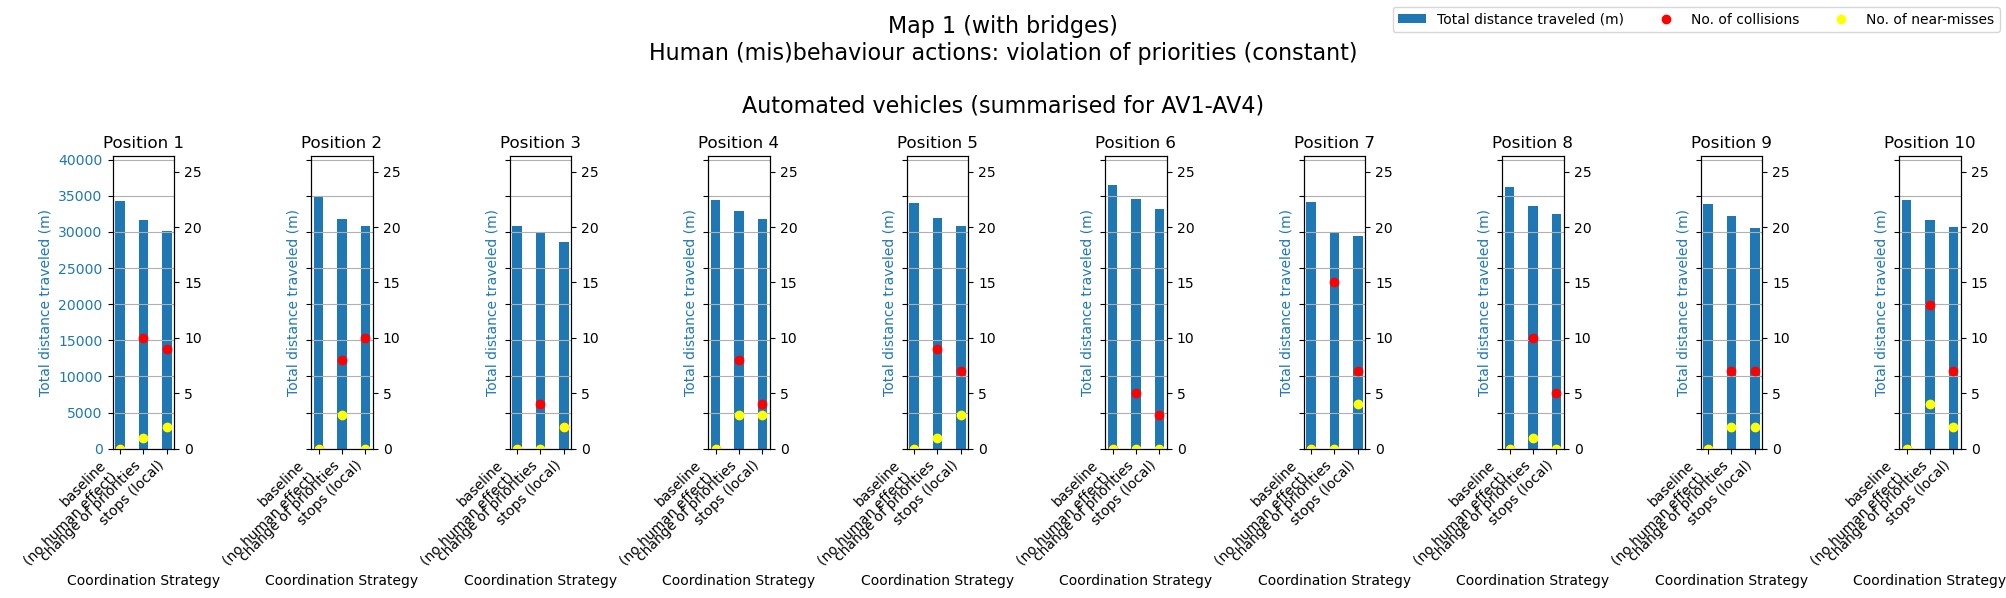

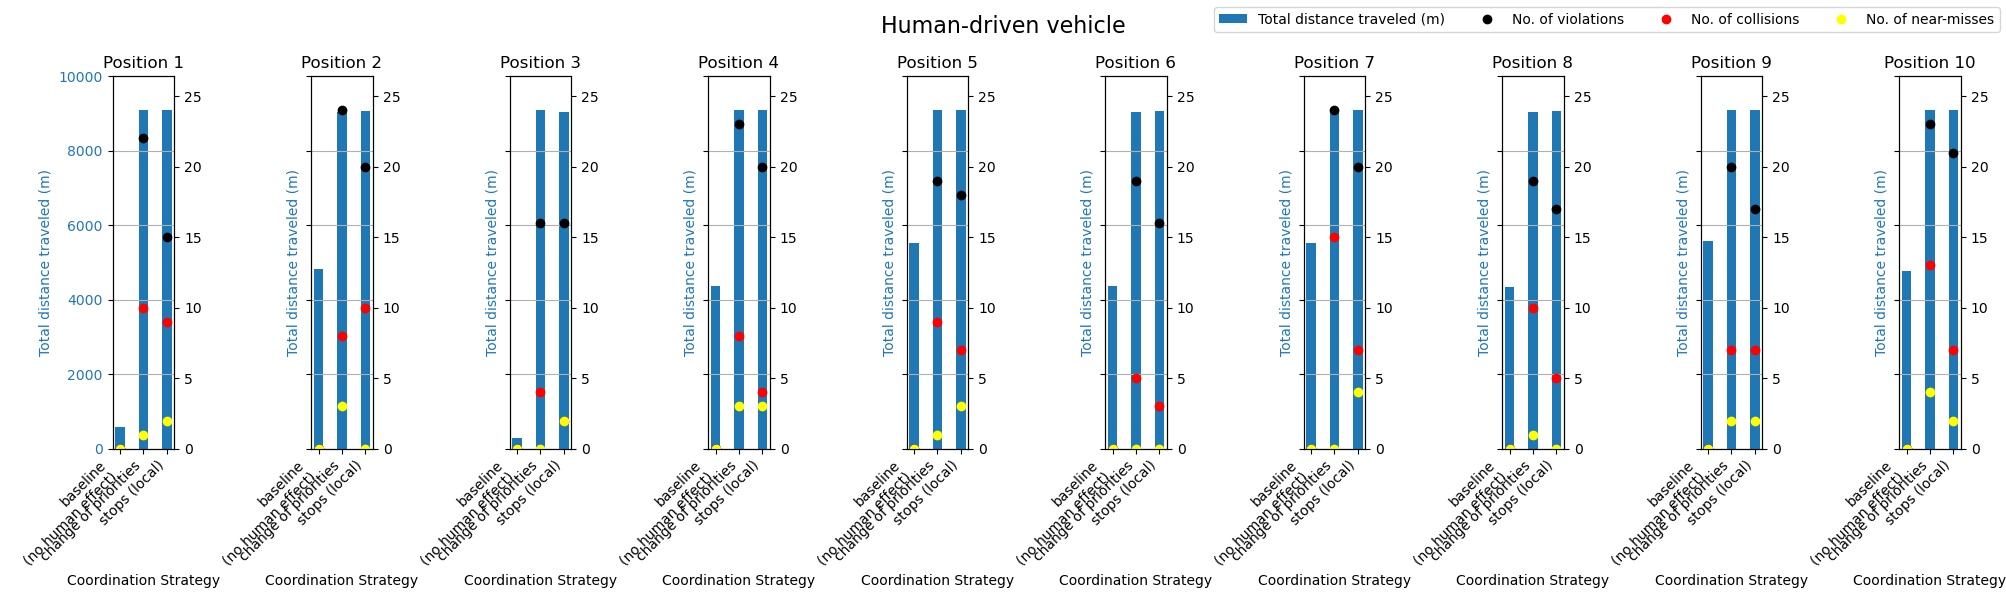

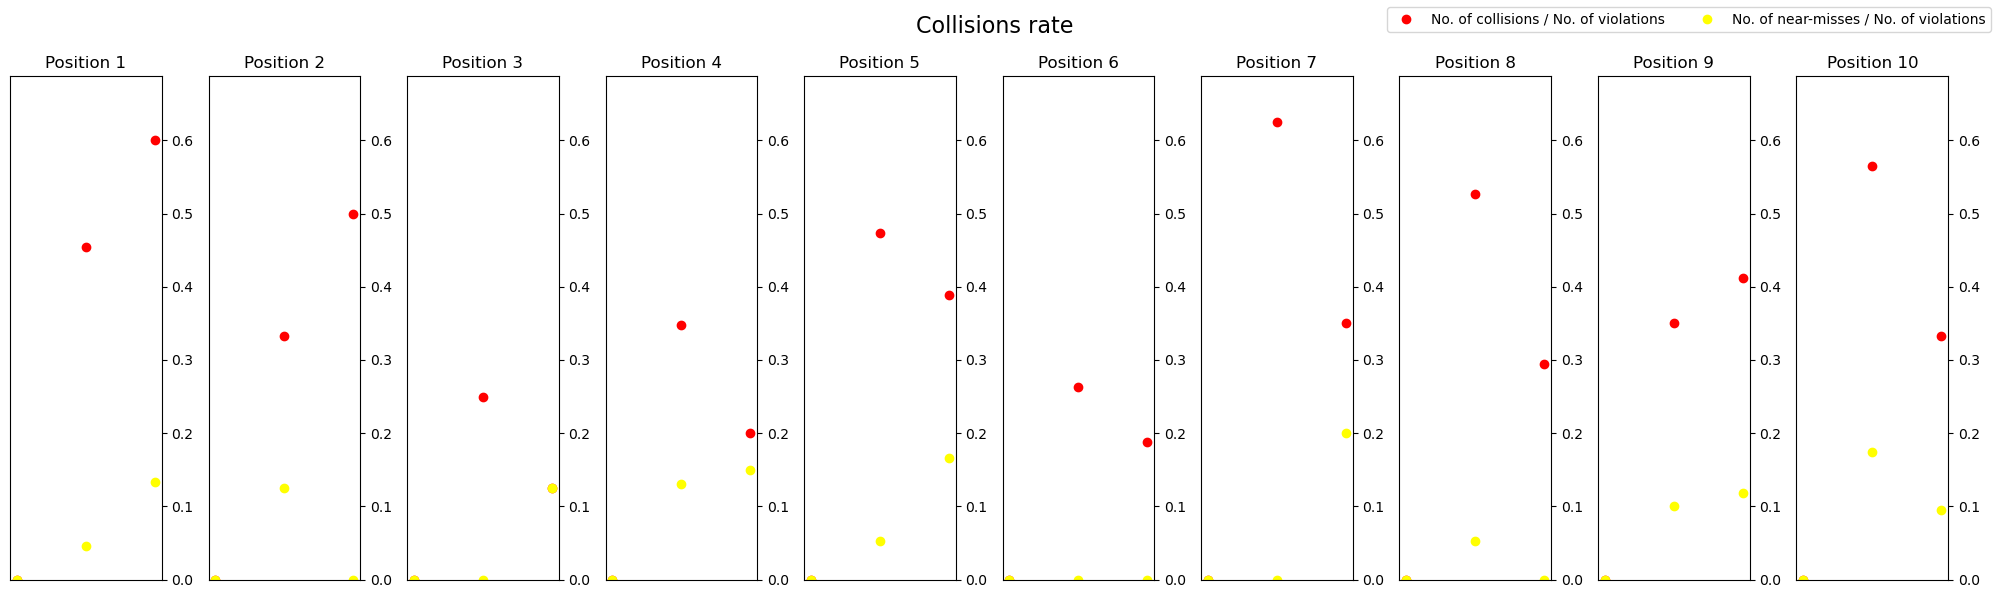

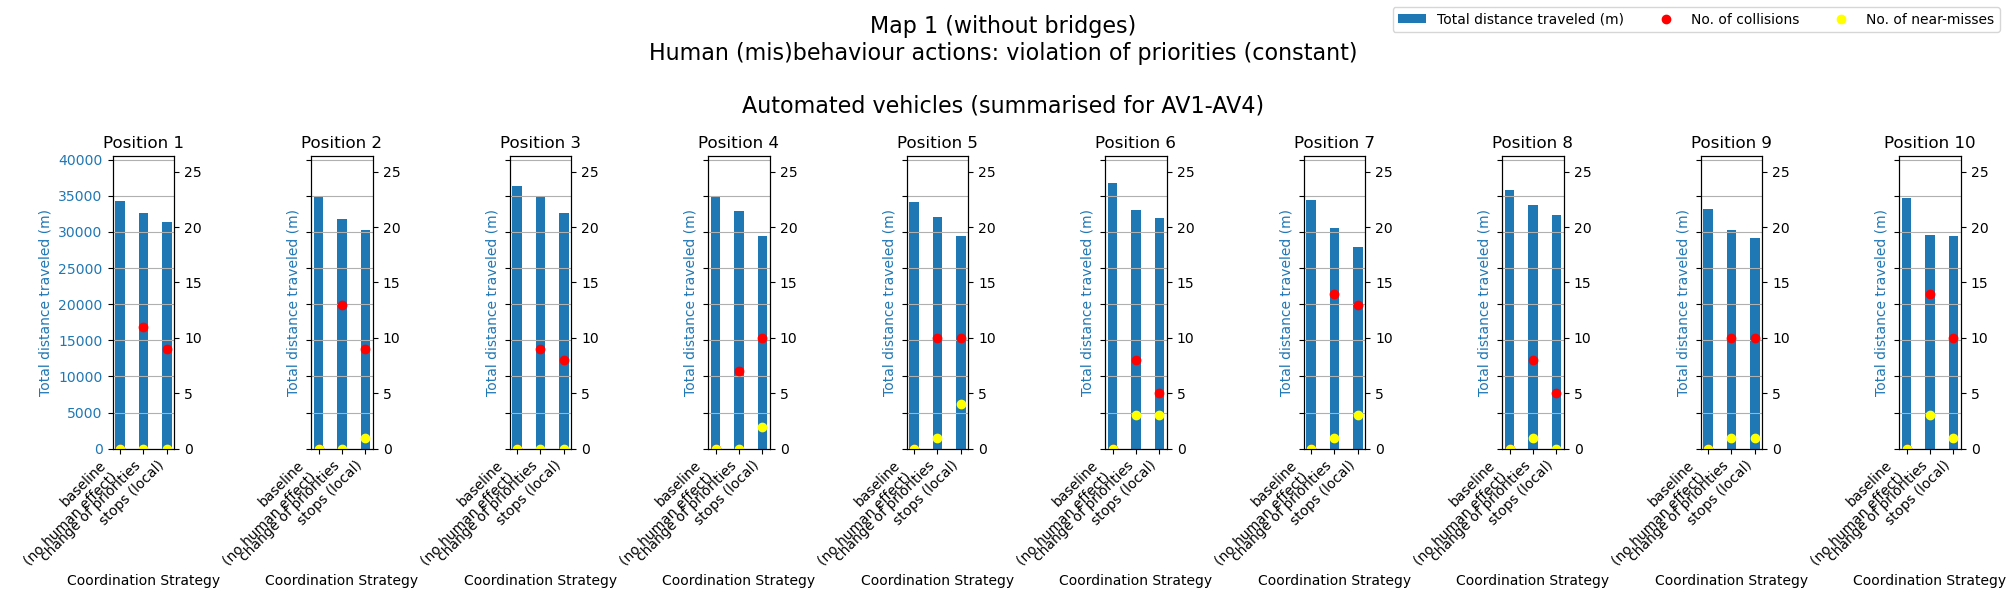

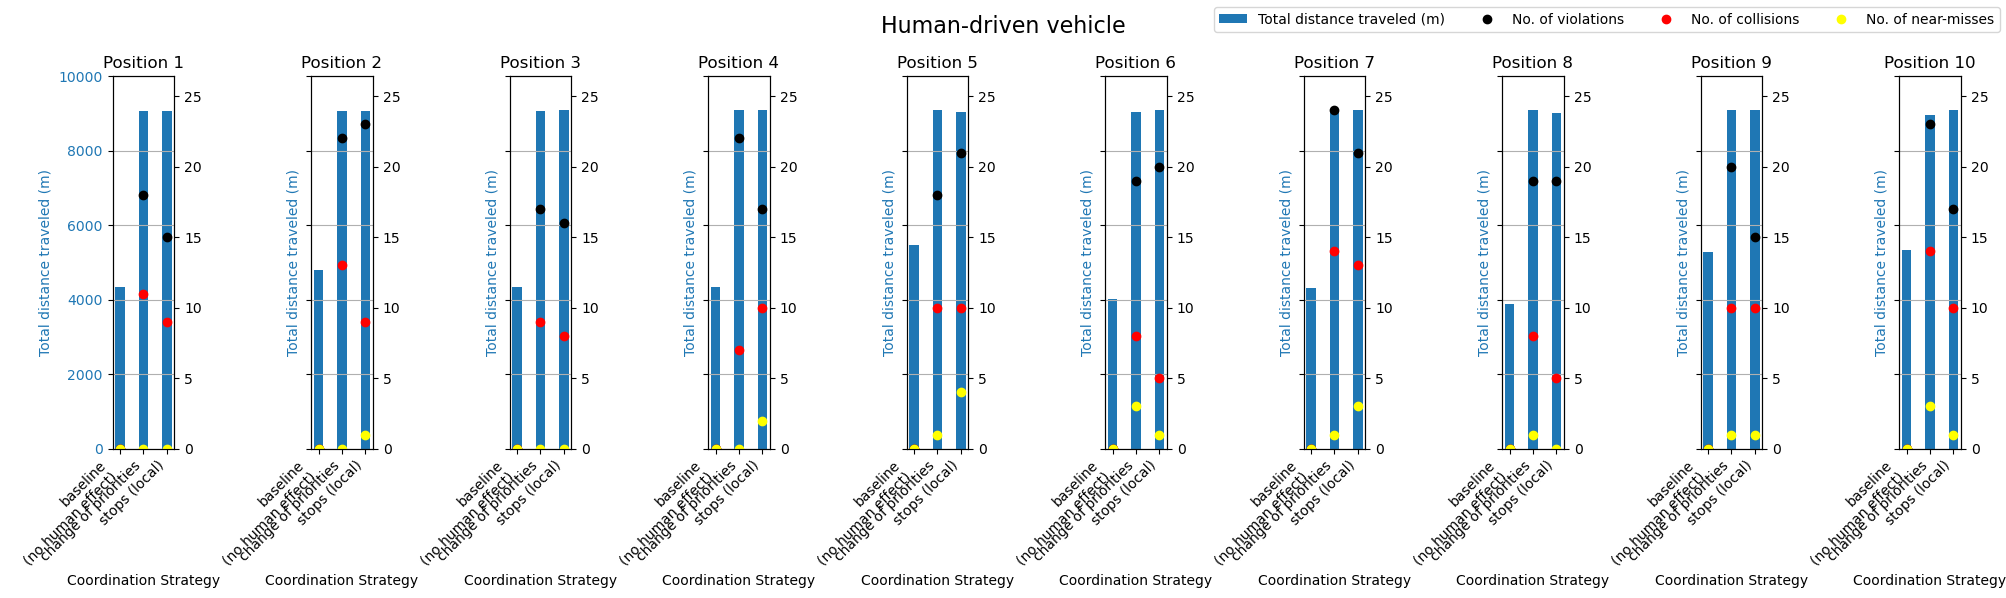

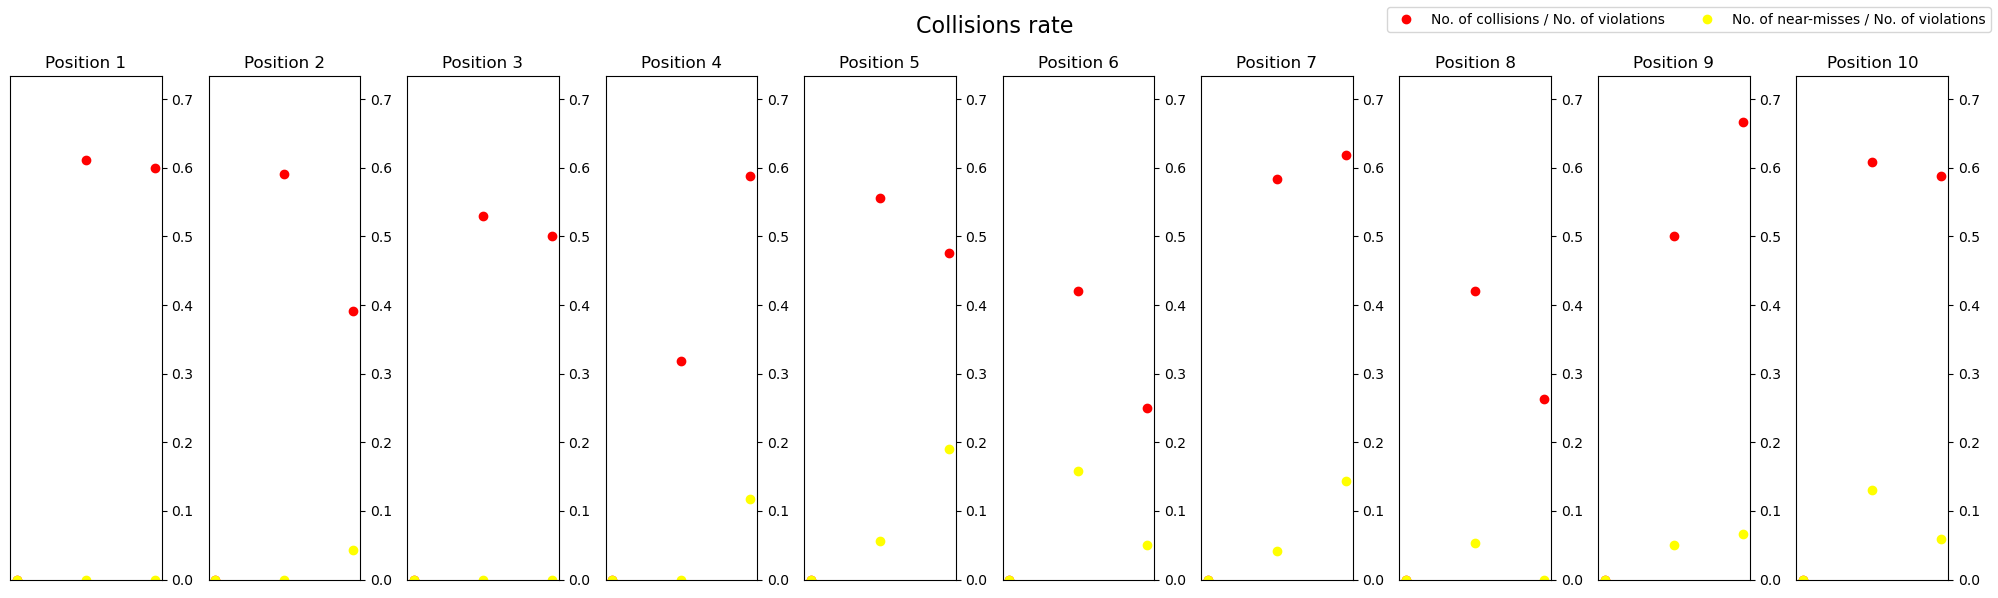

In [7]:
def save_and_show(fig, basename):  # to avoid inlining large image data into the notebook file
    filename = f'{DIRECTORY_IMAGES}/{basename}.png'
    fig.savefig(filename)
    #fig.close()
    
    # The `random` is because of https://stackoverflow.com/a/43640705.
    IPython.display.display(IPython.display.HTML(f'<img src="{filename}?{random.random()}" alt="{basename}" />'))
    
    return filename


def same_value(series):
    assert series.nunique() == 1, series
    return series.iloc[0]
    

def make_misbehaviors(df_nonbaseline):
    misbehaviors = []
    
    probabilityForcingForHuman = same_value(df_nonbaseline['probabilityForcingForHuman'])
    if probabilityForcingForHuman > 0.0:
        misbehaviors.append(f'violation of priorities ({"random" if probabilityForcingForHuman < 1.0 else "constant"})')
        
    isCanPassFirstActive = same_value(df_nonbaseline['isCanPassFirstActive'])
    if isCanPassFirstActive.startswith('hum=true, '):
        misbehaviors.append('can pass first')
    elif isCanPassFirstActive.startswith('hum=false, '):
        pass
    else:
        raise ValueError(isCanPassFirstActive)
    
    if 'probabilitySlowingDownForHuman' in df_nonbaseline.columns:
        probabilitySlowingDownForHuman = float(same_value(df_nonbaseline['probabilitySlowingDownForHuman']))
        if probabilitySlowingDownForHuman > 0.0:
            misbehaviors.append(f'moving slowly ({"random" if probabilitySlowingDownForHuman < 1.0 else "constant"})')
    
    return misbehaviors
    
    
class Formula:
    def __init__(self, label, expression=None):
        self.label = label
        self.expression = expression if expression is not None else label
        
    def __str__(self):
        return self.label.replace('`', '')
    
    def __repr__(self):
        return f'<Formula: {self.label!r}>'
    
    def apply(self, df):
        if isinstance(self.expression, str):
            return df.eval(self.expression)
        return df.apply(self.expression, axis=1)
    

def plot_aut_hum(df, *, title2, dfs_y1, dfs_y2, mode):
    #IPython.display.display(df)
    
    # Extract levels
    positions = df.index.get_level_values('Positions variant').unique()
    strategies = df.index.get_level_values('Coordination strategy').unique()
    
    strategy2label = {'baseline': 'baseline\n(no human effect)', 'stops': 'stops (local)'}        
    
    # Plot configuration
    fig, axes = plt.subplots(1, len(positions), figsize=(20, 6), sharey=True, squeeze=False)
    axes: list[list[Axes]]
    bar_width = 0.4
    
    formulas_y2_aut = [Formula('`No. of collisions`'), Formula('`No. of near-misses`')]
    colors_y2_aut = ['red', 'yellow']
    
    formulas_y2_hum = [Formula('`No. of violations`')] + formulas_y2_aut
    colors_y2_hum = ['black'] + colors_y2_aut
    
    formulas_y2_cmp = [Formula(f'`{col}` / `No. of violations`', 
                               lambda row, col=col: row[col] / row['No. of violations'] if row['No. of violations'] > 0 else 0)
                       for col in ('No. of collisions', 'No. of near-misses')]
    colors_y2_cmp = ['red', 'yellow']
    
    if mode in ('aut', 'hum'):
        column_y1 = 'Total distance traveled (m)'
        color_y1 = 'tab:blue'
        
        if mode == 'aut':
            formulas_y2 = formulas_y2_aut
            colors_y2 = colors_y2_aut
            title1 = 'Automated vehicles (summarised for AV1-AV4)' 
        else:
            formulas_y2 = formulas_y2_hum
            colors_y2 = colors_y2_hum
            title1 = 'Human-driven vehicle'
            
    elif mode == 'cmp':
        column_y1 = None
        color_y1 = None
        
        formulas_y2 = formulas_y2_cmp
        colors_y2 = colors_y2_cmp
        title1 = 'Collisions rate'
        
    else:
        raise ValueError(mode)
    
    # Get the global min and max values for consistent y-axis scaling
    y1_max = None if column_y1 is None else max(dfx[column_y1].max() for dfx in dfs_y1)
    y2_maxes = [formula.apply(dfx).max()
                for dfx in dfs_y2
                for formula in (formulas_y2 if mode == 'cmp' else set(formulas_y2_aut + formulas_y2_hum))]
    y2_max = max(y2_maxes)
    #print(y2_max, formulas_y2, y2_maxes)
    #print(f'{dfs_y2=}')
    
    # Iterate through each Positions variant
    for i, position in enumerate(positions):
        ax = axes[0][i]
        df_pos = df.loc[position]
        
        # Bar positions for each Coordination strategy
        x_positions = np.arange(len(strategies))
        
        # Plot bars
        handles = []
        if column_y1 is not None:
            handles += [ax.bar(x_positions, df_pos[column_y1], width=bar_width, label=column_y1, color=color_y1)[0]]
            ax.set_xlabel('Coordination Strategy')
            ax.set_ylabel(column_y1, color=color_y1)
            ax.tick_params(axis='y', labelcolor=color_y1)
            ax.set_ylim(0, y1_max * 1.1)
        else:
            ax.set_axis_off()
        
        # Create a secondary axis for the points
        ax_right = ax.twinx()
        
        # Plot points
        handles += [ax_right.plot(x_positions, formula.apply(df_pos), label=str(formula),
                                  marker='o', linestyle='', color=color)[0]
                    for formula, color in zip(formulas_y2, colors_y2)]
        ax_right.tick_params(axis='y', labelcolor='black')
        ax_right.set_ylim(0, y2_max * 1.1)
        
        # Add labels, grid, and title for each section
        ax.set_xticks(x_positions)
        ax.set_xticklabels([strategy2label.get(s, s) for s in strategies], rotation=45, ha='right')
        ax.set_title(f'Position {position}')
        ax.grid(axis='y')
        
    misbehaviors = make_misbehaviors(df[df['Coordination strategy'] != 'baseline'])
    title3 = 'Human (mis)behaviour actions: ' + ('none' if not misbehaviors else ', '.join(misbehaviors))    
    
    title = title1
    if mode == 'aut':
        title = f'{title2}\n{title3}\n\n{title}'
    fig.suptitle(title, fontsize=16)
    
    labels = [str(x) for x in [column_y1, *formulas_y2] if x is not None]
    fig.legend(handles=handles, labels=labels, ncol=len(handles), loc='upper right')
    
    fig.tight_layout()
    filename_png = save_and_show(fig, f'{title1}: {title2}')
    
    #print(id(df))
    #IPython.display.display(df)
    
    return filename_png


key2df = {}
for are_bridges in True, False:
    for is_aut in True, False:
        dfx = df[df['are_bridges'] == are_bridges]
        dfx = dfx[dfx['configuration'].isin(index_nonblocked.get_level_values('configuration'))]
        dfx = dfx[dfx['Vehicle type'] == ('AutonomousVehicle' if is_aut else 'HumanDrivenVehicle')]
        dfx = dfx.groupby(['Positions variant', 'Coordination strategy']).agg({
            **{col: 'sum' for col in dfx.columns},
            **{col: same_value for col in (
                'Positions variant', 'Coordination strategy', 'configuration', 
                'probabilityForcingForHuman', 'isCanPassFirstActive', 'probabilitySlowingDownForHuman',
            ) if col in dfx.columns}
        })
        key2df[are_bridges, is_aut] = dfx    
        
for are_bridges in True, False:
    filenames_png = []
    for mode in 'aut', 'hum', 'cmp':
        is_aut = mode == 'aut'
        try:
            filename_png = plot_aut_hum(
                key2df[are_bridges, is_aut],
                title2=f"Map {I_MAP} ({'with' if are_bridges else 'without'} bridges)", 
                dfs_y1=[dfx for (_, is_aut_dfx), dfx in key2df.items() if is_aut_dfx == is_aut], 
                dfs_y2=key2df.values() if mode != 'cmp' else [key2df[are_bridges, is_aut]], 
                mode=mode,
            )
            filenames_png.append(filename_png)
        except Exception as exc:
            #print(type(exc), exc)
            raise exc
    #IPython.display.display(dfx)
    filename_out_png = f'{DIRECTORY_IMAGES}/All: Map {I_MAP} (' + ('with' if are_bridges else 'without') + ' bridges).png'
    subprocess.run(['convert', *filenames_png, '-append', filename_out_png], check=True)
    print()

Non-blocked: Map 1 (with bridges): 3x4


Non-blocked: Map 1 (without bridges): 3x4


Blocked: Map 1 (with bridges): 1x4


Blocked: Map 1 (without bridges): 1x4


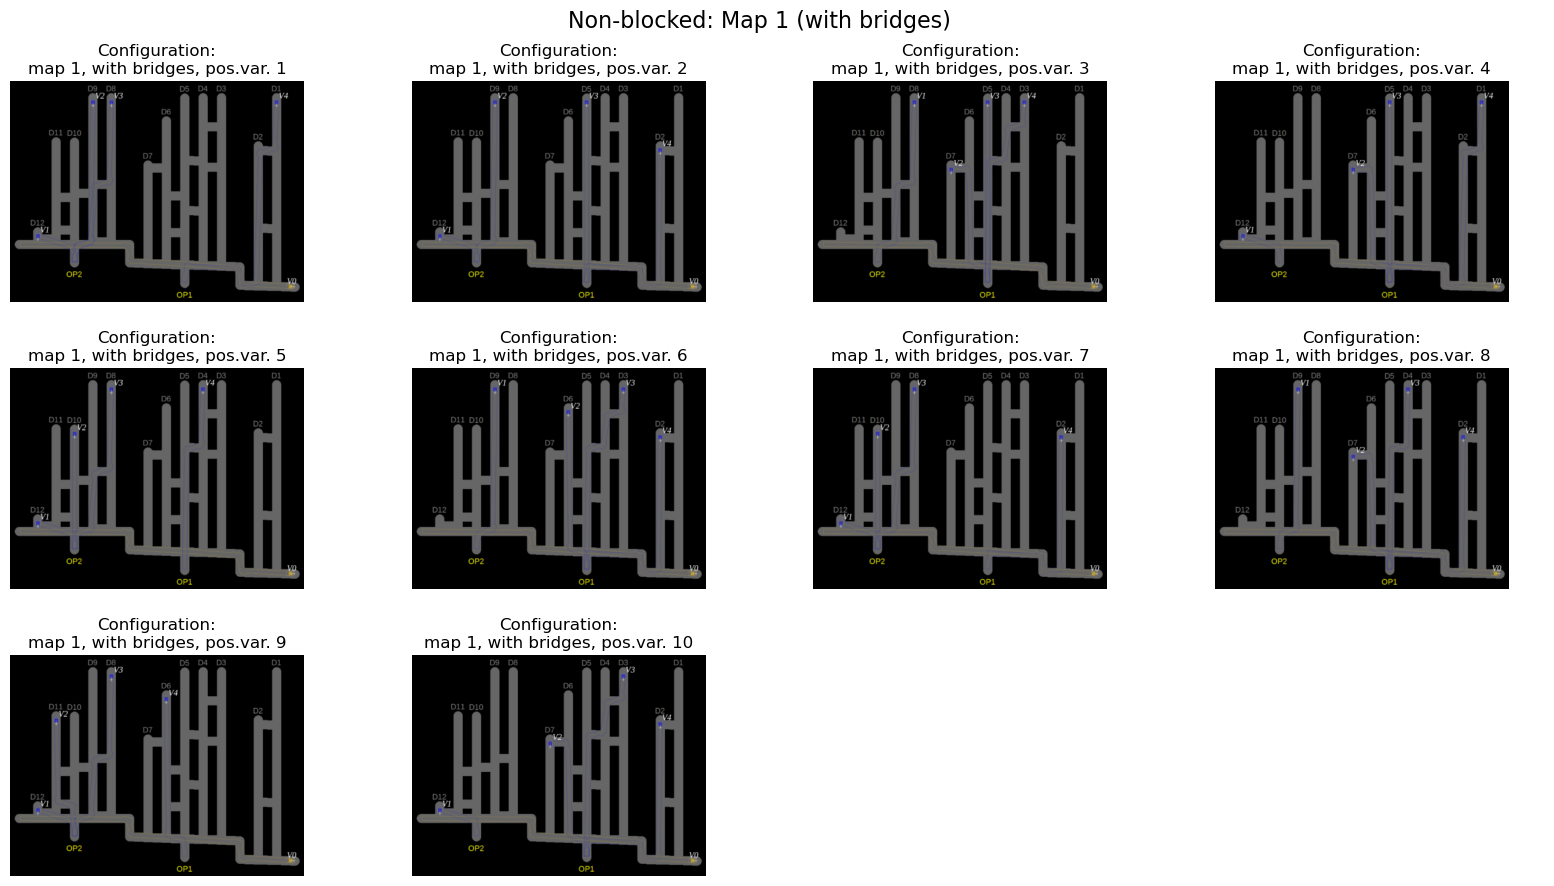

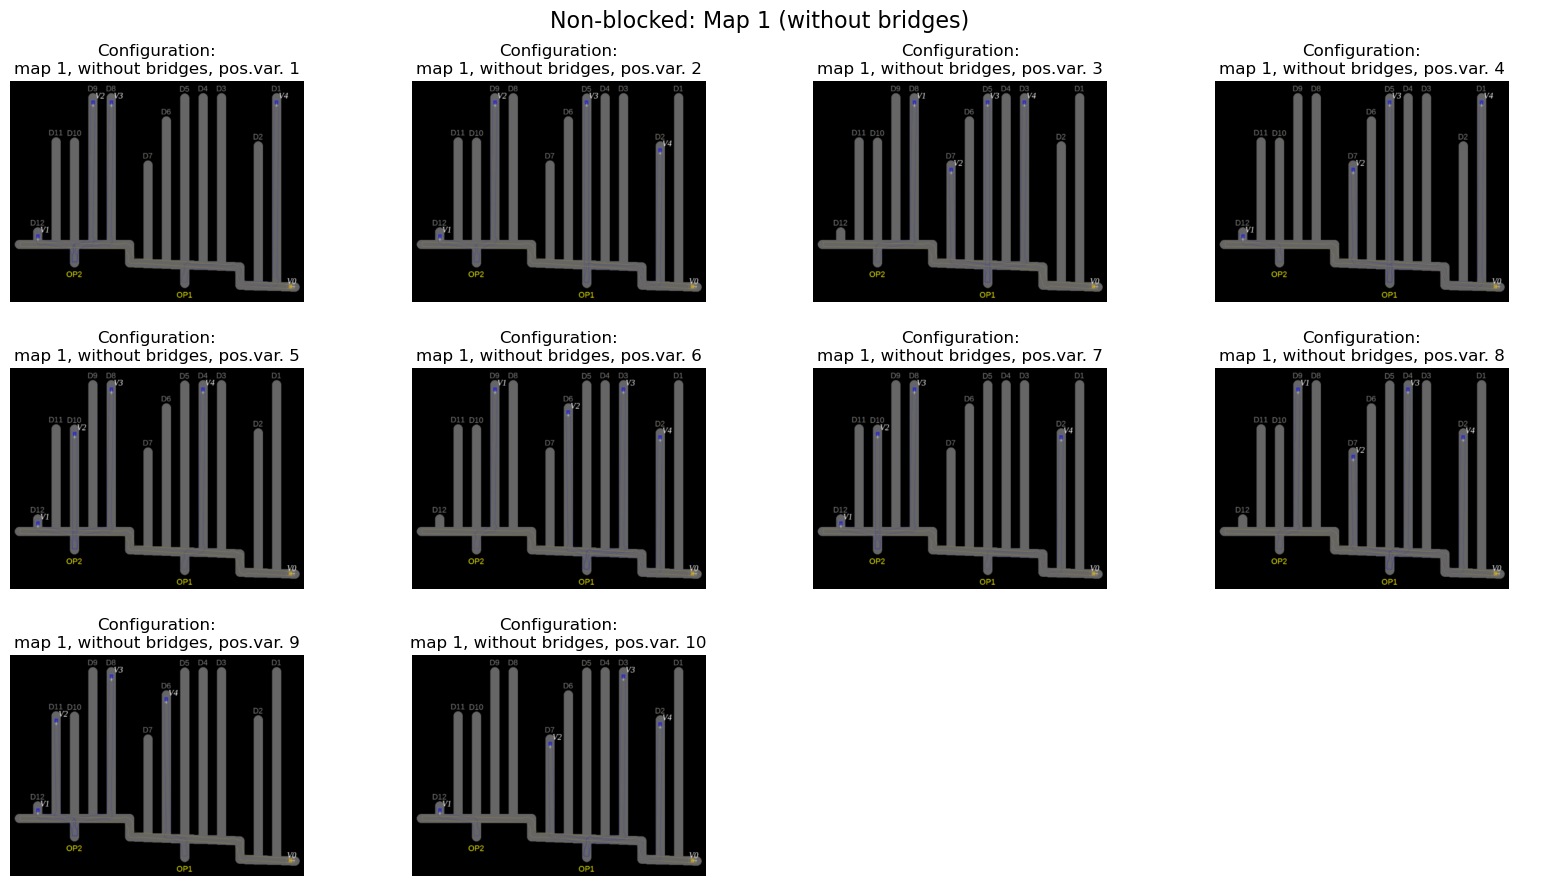

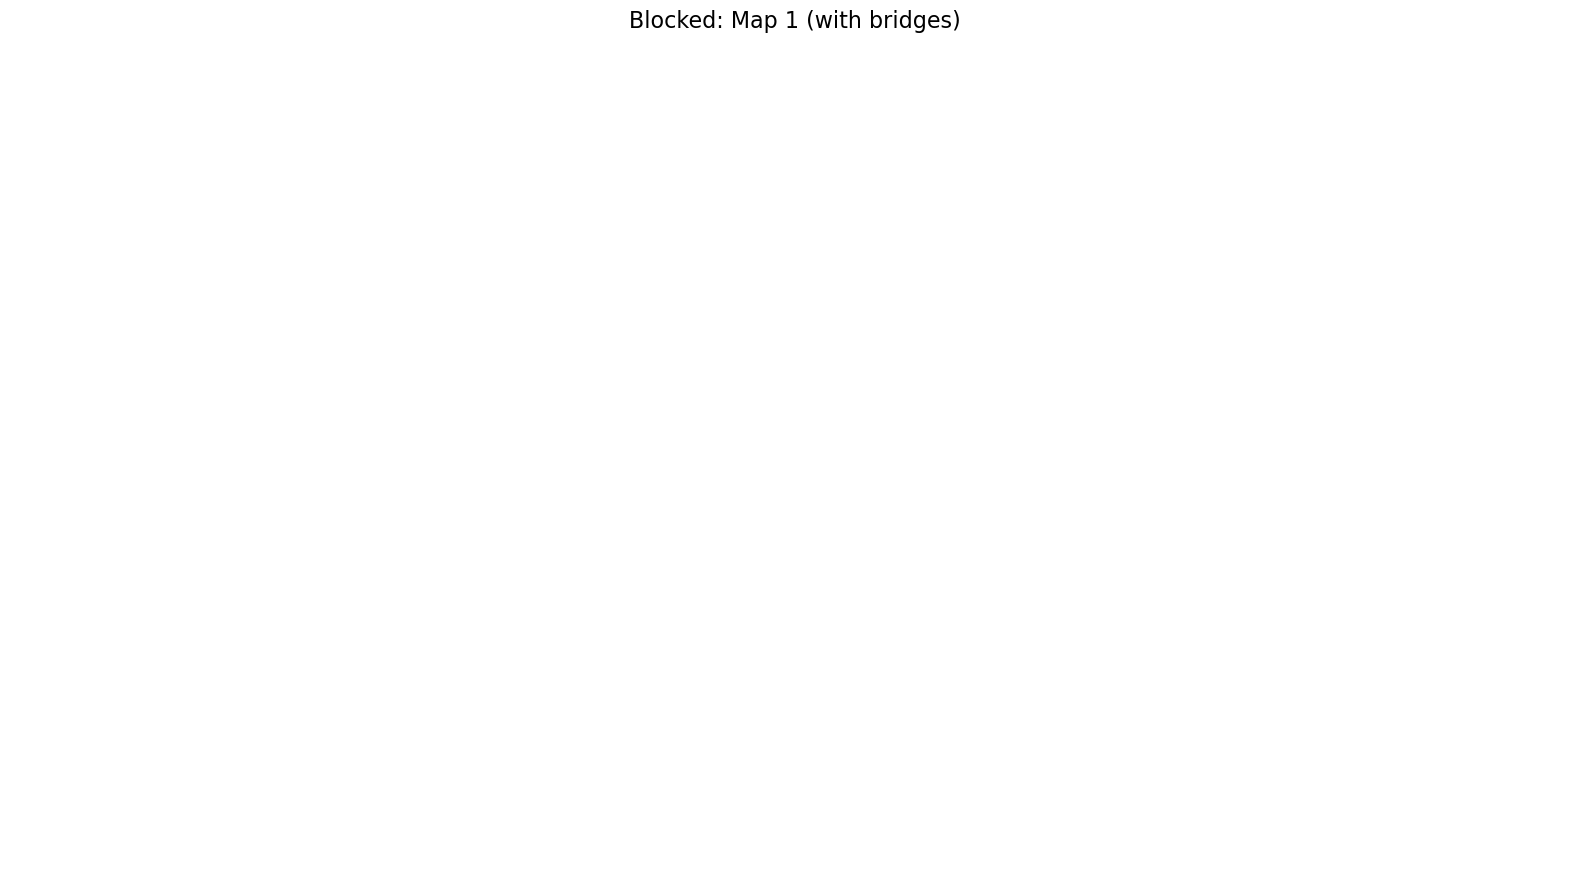

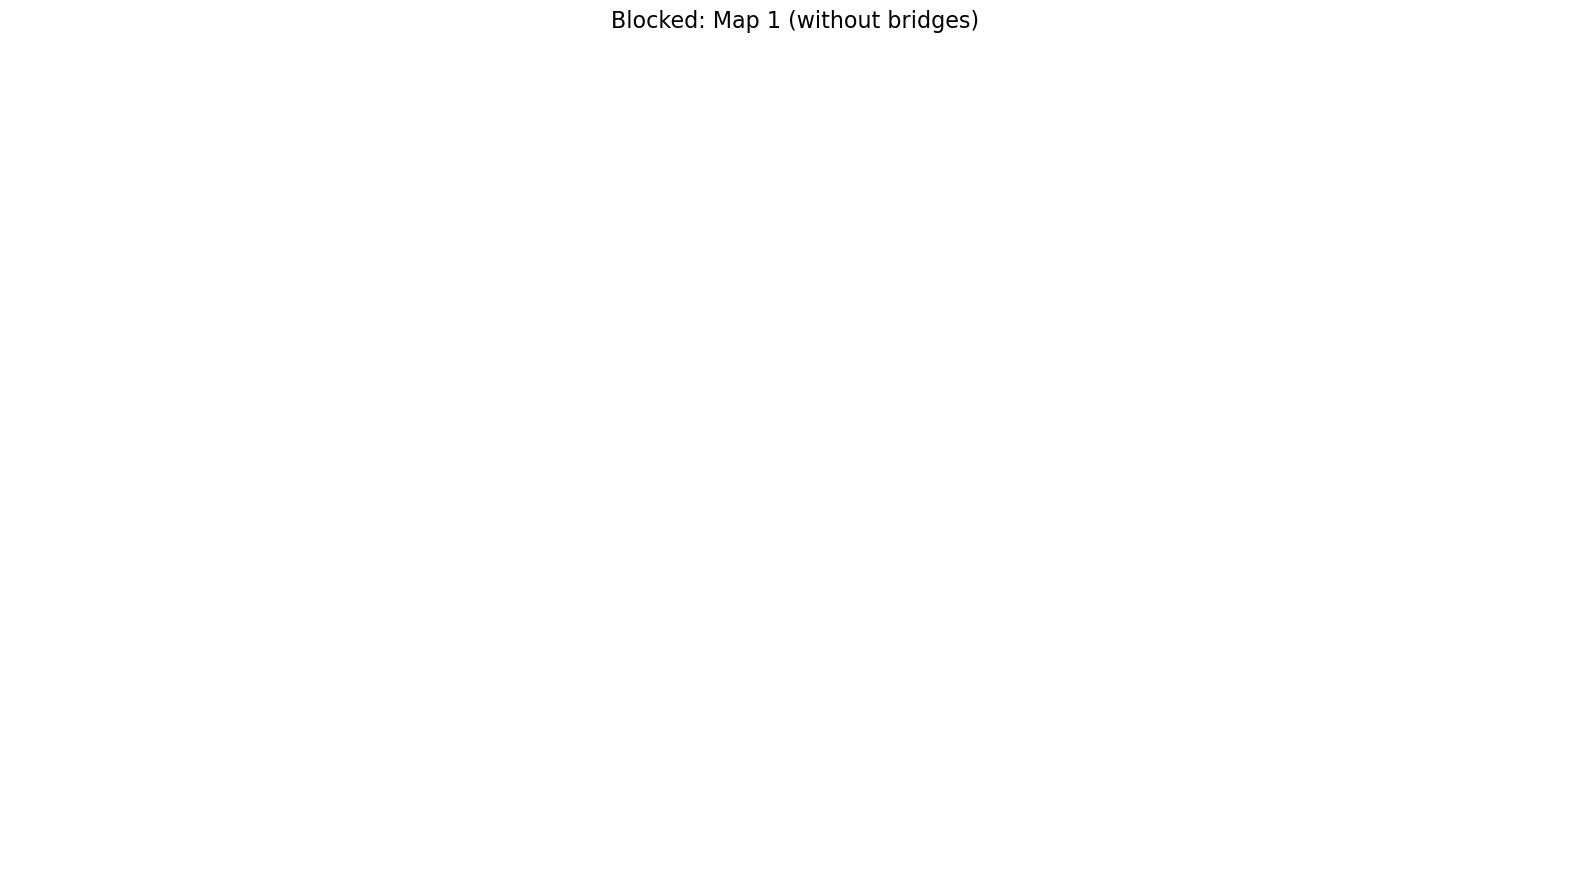

In [8]:
def show_maps(title, configurations, ncols): 
    nrows = max(1, (len(configurations) + ncols - 1) // ncols)
    fig, axes_matrix = plt.subplots(nrows, ncols, figsize=(16, 9), squeeze=False)
    print(f'{title}: {nrows}x{ncols}')

    axes = list(itertools.chain.from_iterable(axes_matrix))
    axes_matrix: list[list[Axes]]
    assert len(axes) >= len(configurations)
    
    for ax in axes:
        ax.axis('off')
        
    for ax, configuration in zip(axes, configurations):
        filename_screenshot = configuration_to_filename_screenshot[configuration]
        try:
            image = plt.imread(filename_screenshot)
            ax.imshow(image)
        except Exception as exc:
            print(exc)
        ax.title.set_text(f'Configuration:\n{configuration}')
    
    fig.suptitle(title, fontsize=16)    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.3)
    save_and_show(fig, title)
    
    
for title, index in {'Non-blocked': index_nonblocked, 'Blocked': index_blocked}.items():
    for are_bridges in True, False:
        show_maps(f'{title}: Map {I_MAP} ({"with" if are_bridges else "without"} bridges)', 
                  index[index.get_level_values('are_bridges') == are_bridges].get_level_values('configuration'), 
                  4)